[Reference](https://medium.com/@byeonghyeokyu/torchgeo-an-introduction-to-object-detection-example-b0fd43e89649)

# Installing TorchGeo


In [1]:
%pip install -q -U torchgeo[datasets]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.1/807.1 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.1 MB/s eta 0

# Installing PyTorch Lightning

In [2]:
!pip install -q -U pytorch-lightning

# Downloading the VHR-10 Dataset

In [3]:
import torchgeo
from torchgeo.datasets import VHR10
from torchgeo.trainers import ObjectDetectionTask

import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl

import matplotlib.pyplot as plt

In [4]:
import os, gdown

os.makedirs('data/VHR10/', exist_ok=True)

url = 'https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE'
output_path = 'data/VHR10/NWPU VHR-10 dataset.rar'
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE
From (redirected): https://drive.google.com/uc?id=1--foZ3dV5OCsqXQXT84UeKtrAqc5CkAE&confirm=t&uuid=5fc541af-c81f-4d34-b265-bdcff6a07b38
To: /content/data/VHR10/NWPU VHR-10 dataset.rar
100%|██████████| 76.8M/76.8M [00:04<00:00, 17.1MB/s]


'data/VHR10/NWPU VHR-10 dataset.rar'

In [5]:
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255.0
    return sample

ds = VHR10(
    root="data/VHR10/",
    split="positive",
    transforms=preprocess,
    download=True,
    checksum=True,
)

Using downloaded and verified file: data/VHR10/NWPU VHR-10 dataset.rar
Extracting data/VHR10/NWPU VHR-10 dataset.rar to data/VHR10/


100%|██████████| 1265416/1265416 [00:00<00:00, 157162636.30it/s]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


# Exploring the VHR-10 Dataset

In [6]:
print(f"VHR-10 dataset: {len(ds)}")

VHR-10 dataset: 650


In [7]:
ds[0]["image"].shape

torch.Size([3, 808, 958])

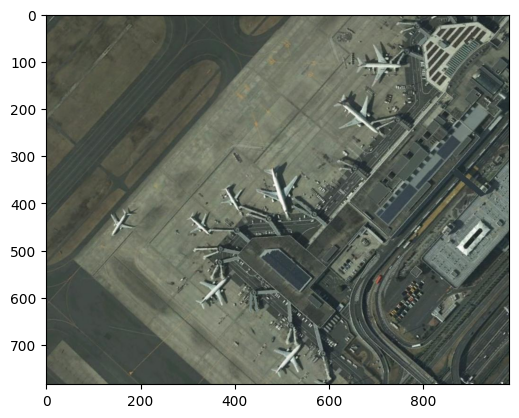

In [8]:
image = ds[5]["image"].permute(1, 2, 0)
plt.imshow(image)
plt.show()

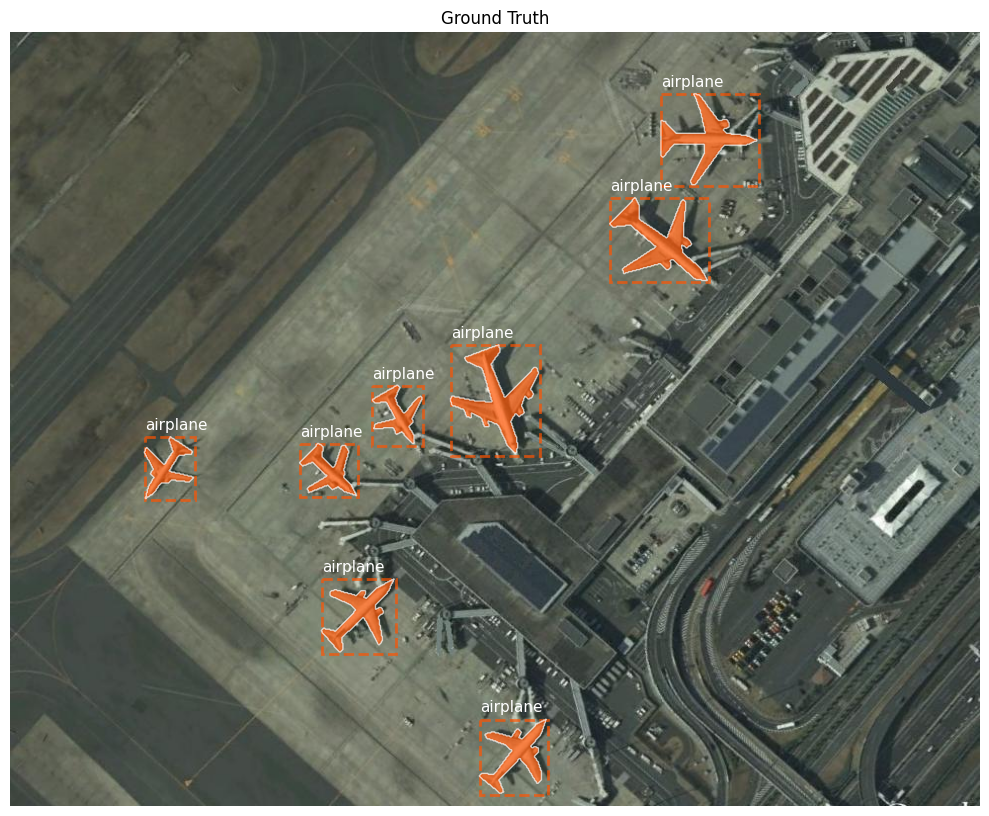

In [9]:
ds.plot(ds[5])
plt.savefig('ground_truth.png', bbox_inches='tight')
plt.show()

# Model Training

In [16]:
def collate_fn(batch):
    new_batch = {
        "image": [item["image"] for item in batch],  # Images
        "boxes": [item["boxes"] for item in batch],  # Bounding boxes
        "labels": [item["labels"] for item in batch],  # Labels
        "masks": [item["masks"] for item in batch],  # Masks
    }
    return new_batch  # Return the new batch

# Data Loader

dl = DataLoader(
    ds,  # Dataset
    batch_size=16,  # Number of data to load at one time
    num_workers=2,  # Number of processes to use for data loading
    shuffle=True,  # Whether to shuffle the dataset before loading
    collate_fn=collate_fn,  # collate_fn function for batch processing
)

In [17]:
class VariableSizeInputObjectDetectionTask(ObjectDetectionTask):
    # Define the training step
    def training_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch["image"]  # Image
        batch_size = len(x)  # Set batch size (number of images)
        y = [
            {"boxes": batch["boxes"][i], "labels": batch["labels"][i]}
            for i in range(batch_size)
        ] # Extract bounding box and label information for each image
        loss_dict = self(x, y)  # Loss
        train_loss: Tensor = sum(loss_dict.values())  # Training loss (sum of loss values)
        self.log_dict(loss_dict)  # Record loss values
        return train_loss  # Return training loss

task = VariableSizeInputObjectDetectionTask(
    model="faster-rcnn",  # Faster R-CNN model
    backbone="resnet18",  # ResNet18 neural network architecture
    weights=True,  # Use pretrained weights
    in_channels=3,  # Number of channels in the input image (RGB images)
    num_classes=11,  # Number of classes to classify (10 + background)
    trainable_layers=3,  # Number of trainable layers
    lr=1e-3,  # Learning rate
    patience=10,  # Set the number of patience iterations for early stopping
    freeze_backbone=False,  # Whether to train with the backbone network weights unfrozen
)
task.monitor = "loss_classifier"  # Set the metric to monitor (here, the classifier's loss)

In [18]:
trainer = pl.Trainer(
    default_root_dir="logs/",  # Set the default directory
    accelerator="gpu",  # Set the type of hardware accelerator for training (using GPU)
    devices=[0],  # List of device IDs to use ([0] means the first GPU)
    min_epochs=6,  # Set the minimum number of training epochs
    max_epochs=10,  # Set the maximum number of training epochs
    log_every_n_steps=20,  # Set how often to log after a number of steps
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
%%time
# Model training
trainer.fit(task, train_dataloaders=dl)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | val_metrics  | MetricCollection | 0      | train
1 | test_metrics | MetricCollection | 0      | train
2 | model        | FasterRCNN       | 28.3 M | train
----------------------------------------------------------
28.2 M    Trainable params
156 K     Non-trainable params
28.3 M    Total params
113.280   Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | val_metrics  | MetricCollection | 0      | train
1 | test_metrics | MetricCollection | 0      | train
2 | model        | FasterRCNN       | 28.3 M | train
--------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 10min 14s, sys: 27.5 s, total: 10min 42s
Wall time: 10min 49s


# Model Inference Example

In [20]:
batch = next(iter(dl))

In [21]:
model = task.model
model.eval()

with torch.no_grad():
  out = model(batch["image"])

In [22]:
def create_sample(batch, out, batch_idx):
    return {
        "image": batch["image"][batch_idx],  # Image
        "boxes": batch["boxes"][batch_idx],  # Actual bounding boxes
        "labels": batch["labels"][batch_idx],  # Actual labels
        "masks": batch["masks"][batch_idx],  # Actual masks
        "prediction_labels": out[batch_idx]["labels"],  # Labels predicted by the model
        "prediction_boxes": out[batch_idx]["boxes"],  # Bounding boxes predicted by the model
        "prediction_scores": out[batch_idx]["scores"],  # Confidence scores for each prediction
    }

batch_idx = 0
sample = create_sample(batch, out, batch_idx)

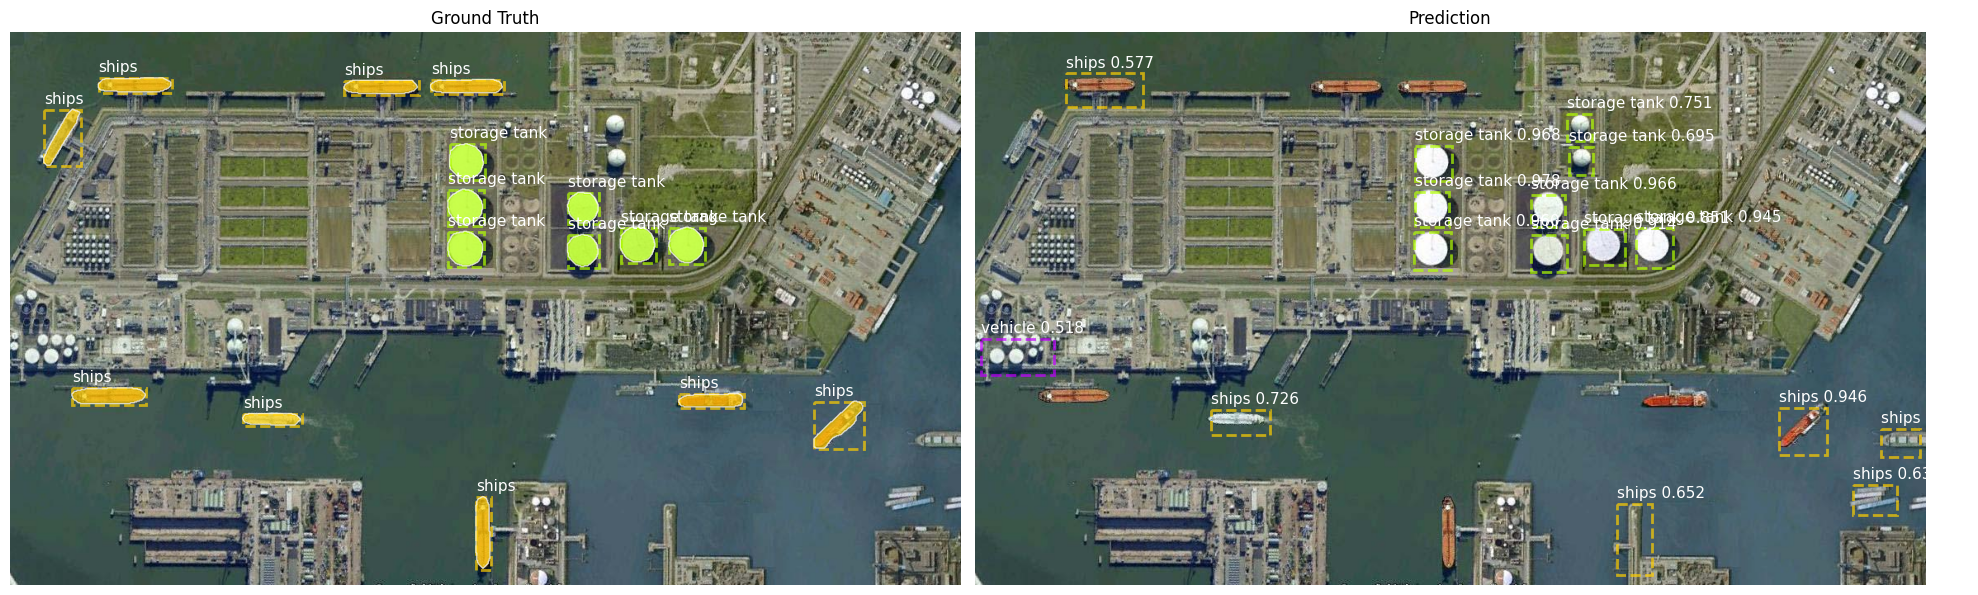

In [23]:
ds.plot(sample)
plt.savefig('inference.png', bbox_inches='tight')
plt.show()

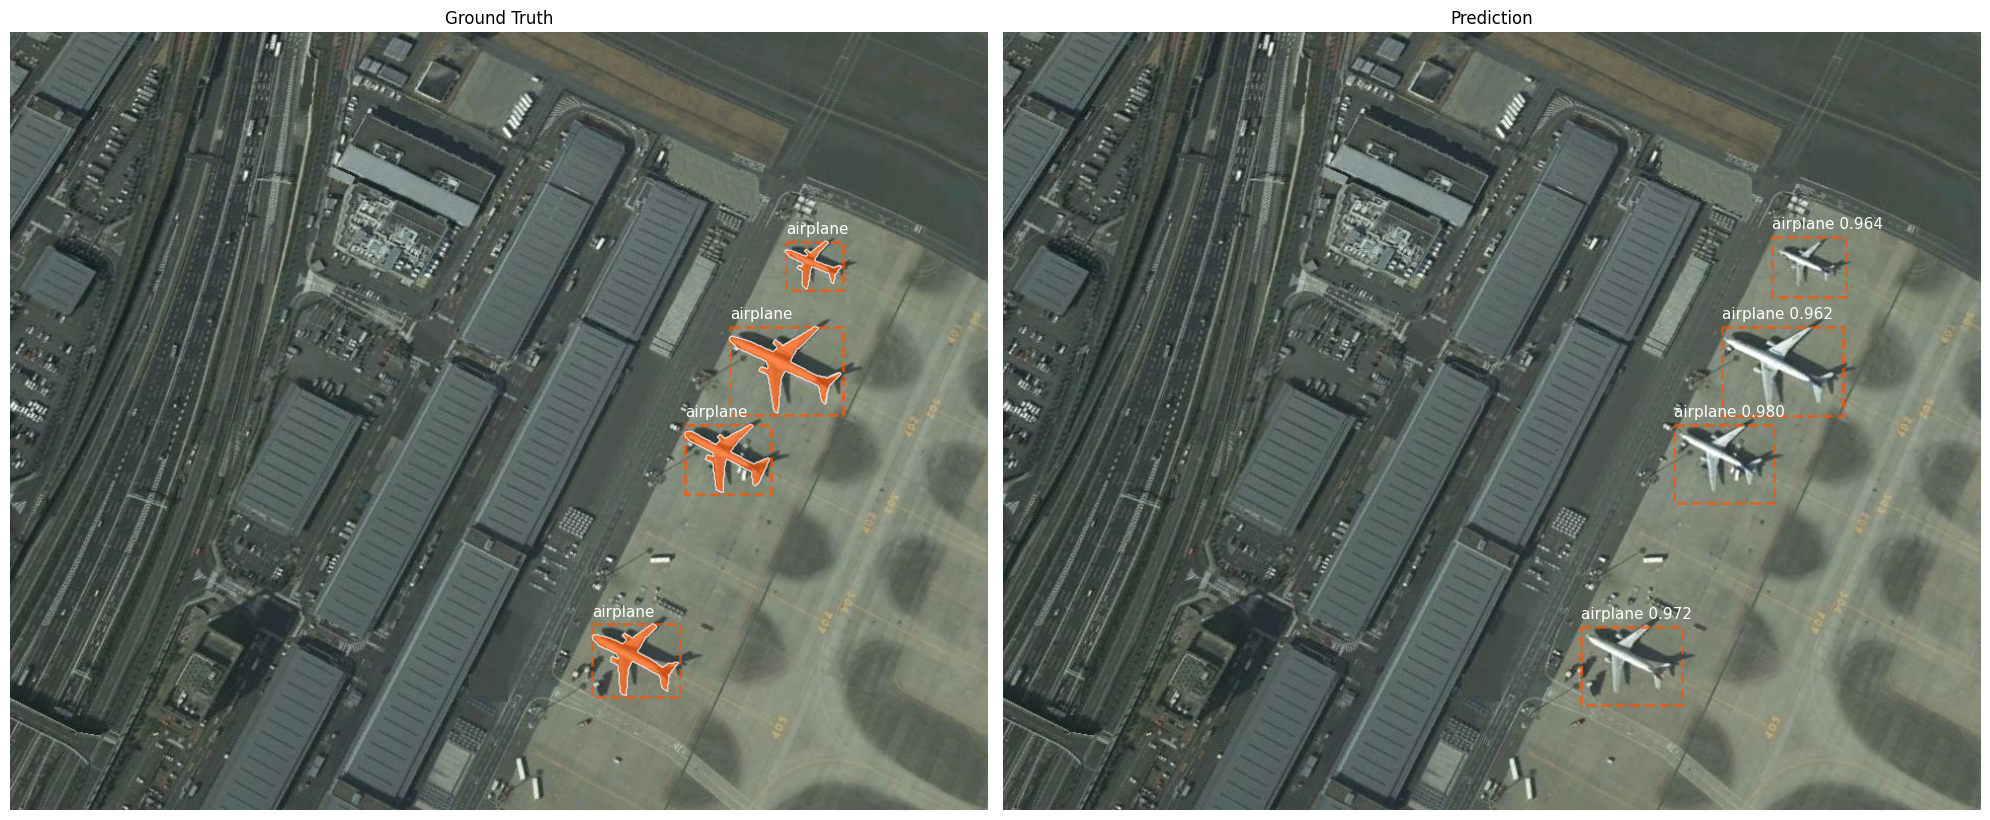

In [24]:
# Visualizing Sample for Batch Index 3
batch_idx = 3
sample = create_sample(batch, out, batch_idx)

ds.plot(sample)
plt.show()

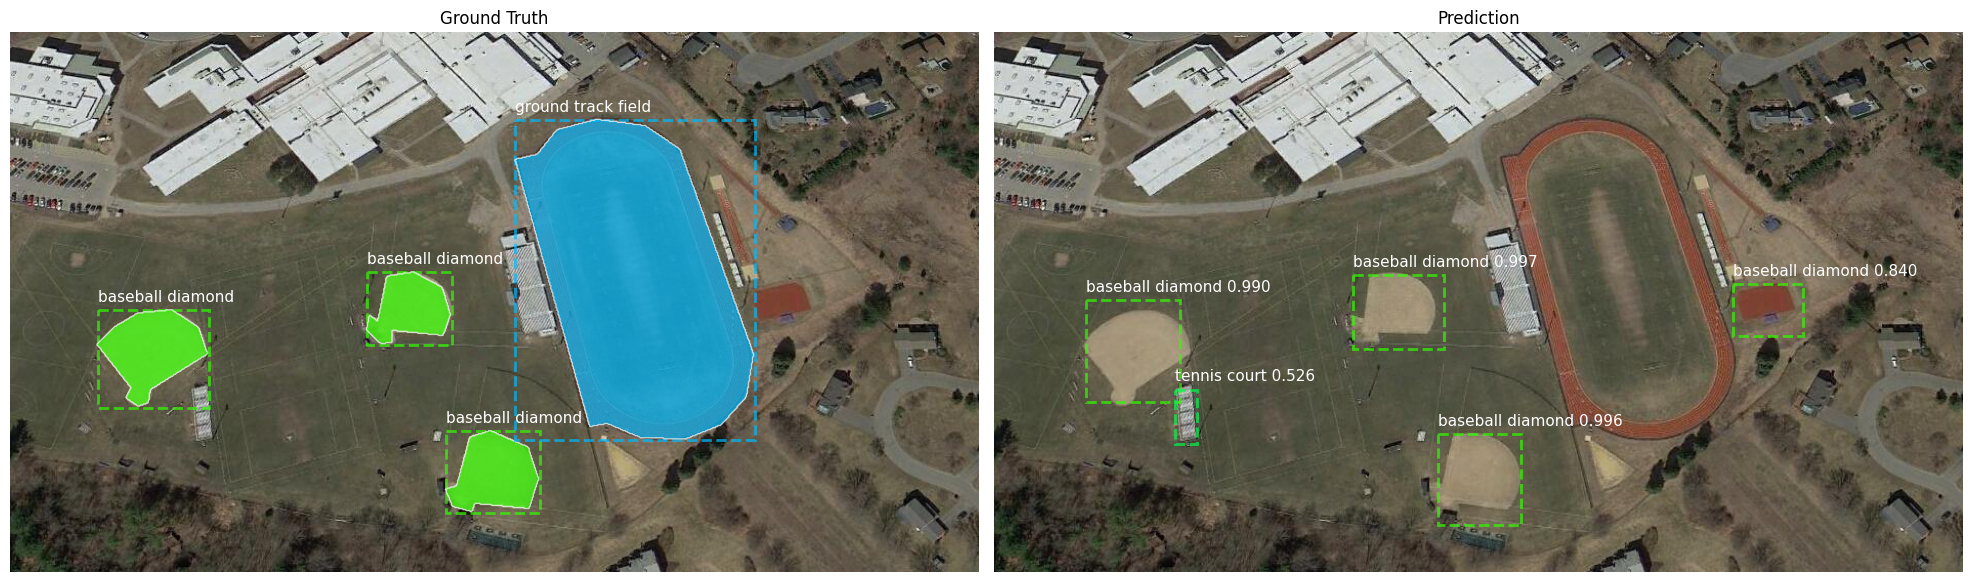

In [25]:
# Visualizing Sample for Batch Index 5
batch_idx = 5
sample = create_sample(batch, out, batch_idx)

ds.plot(sample)
plt.show()